In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
import gc
import sys
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import seaborn as sns
import pandas.core.indexes as i
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
import keras
from keras import layers


In [ ]:
copied_path='/content/drive/MyDrive/9z_ML_Bootcamp/Wafer_Defects/1LSWMD.pkl'
data=pd.read_pickle(copied_path)


In [ ]:
data_backup=data
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
# if need restart, restart from here. reading data took too long
resize_img=26
RGB=1



data=data_backup
data=shuffle(data)




In [ ]:
# remove the [] in failure type. easier for onehot encoder
label=data.trianTestLabel.values
label = [ str(obj).replace("[[", "").replace("]]", "") for obj in label ]
label = np.array(label)
len(label)

811457

In [ ]:
data

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
337620,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5168.0,lot20322,18.0,[],[]
133130,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2418.0,lot8754,25.0,[],[]
278010,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3026.0,lot17074,1.0,[],[]
449800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot27592,2.0,[],[]
665221,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",712.0,lot41432,21.0,[],[]
...,...,...,...,...,...,...
409956,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1970.0,lot24451,9.0,[],[]
706334,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",516.0,lot43278,16.0,[],[]
671284,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",712.0,lot41785,20.0,[],[]
575811,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",686.0,lot36014,22.0,[],[]


In [ ]:
failuretype=data.failureType.values
failuretype = [ str(obj).replace("[['", "").replace("']]", "") for obj in failuretype ]
failuretype = np.array(failuretype)
len(failuretype)

811457

In [ ]:
df=pd.DataFrame()
df['label']=label
df['type']=failuretype
df['wafermap']=data.waferMap.values
df['diesize']=data['dieSize'].values
df['lot']=data.lotName.values
df['waferindex']=data.waferIndex
df.drop(df[df['type']=='[]'].index,axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172950 entries, 12 to 811456
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       172950 non-null  object 
 1   type        172950 non-null  object 
 2   wafermap    172950 non-null  object 
 3   diesize     172950 non-null  float64
 4   lot         172950 non-null  object 
 5   waferindex  172950 non-null  float64
dtypes: float64(2), object(4)
memory usage: 9.2+ MB


In [ ]:
types=df['type'].unique()
types

array(['none', 'Loc', 'Random', 'Edge-Ring', 'Edge-Loc', 'Scratch',
       'Center', 'Near-full', 'Donut'], dtype=object)

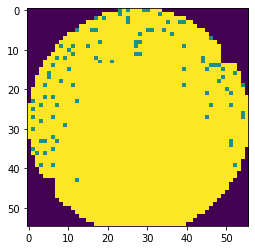

In [ ]:
map_temp=df[df.type=="Near-full"].wafermap.to_numpy()
c=map_temp[1]
c.shape
plt.imshow(c.flatten().reshape(c.shape[0],c.shape[1]))


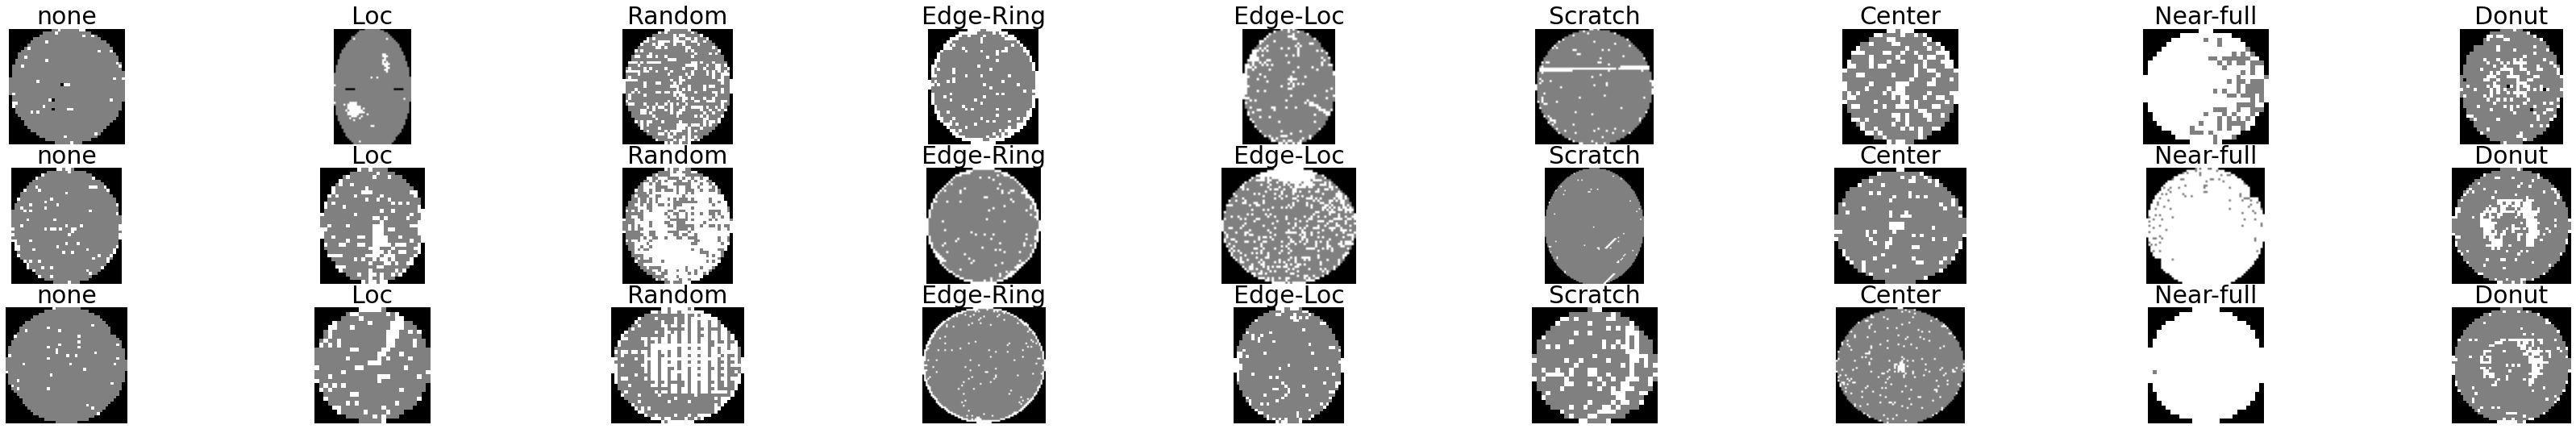

In [ ]:
# example of each defects
rows=3
m=len(types)
fig,ax=plt.subplots(rows, m,figsize=(60,9))
for f,ftype in enumerate(types):
    for i in range(rows):
        plt.subplot(rows,len(types),i*len(types)+f+1) 
        plt.axis('off')
        map_temp=df[df.type==ftype].wafermap.to_numpy()[i]
        plt.figsize=(3,3)
        plt.imshow(map_temp.flatten().reshape(map_temp.shape[0],map_temp.shape[1]), cmap="gray")
        plt.title(ftype,fontsize=30)


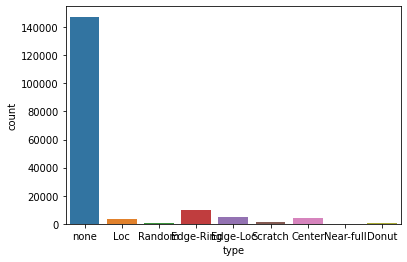

In [ ]:

sns.countplot(df.type) # need undersample, perfect wafer has too many samples!

In [ ]:
# downsample 
imgs=df[df.type != 'none']['wafermap']
label=df[df.type != 'none']['type']

len(imgs.to_numpy())
label

22              Loc
52              Loc
126          Random
216       Edge-Ring
241        Edge-Loc
            ...    
811123       Center
811173    Edge-Ring
811220          Loc
811382       Random
811407     Edge-Loc
Name: type, Length: 25519, dtype: object

In [ ]:
none_sample=shuffle(df[df.type == 'none'])

none_downsample=df[df.type == 'none'].iloc[1:len(imgs.to_numpy())//3,:]
imgs_none= none_downsample.wafermap
label_none=none_downsample.type
len(imgs_none)

8505

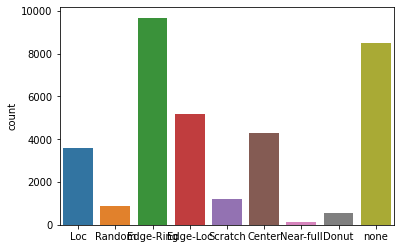

In [ ]:
x=imgs.append(imgs_none).to_numpy()
y=label.append(label_none).to_numpy()
len(y)
sns.countplot(y)

In [ ]:
# downsample, sample too large to fit
batch_fit=pd.DataFrame({'x':x,'y':y})
batch_fit=shuffle(batch_fit)
#batch_fit= batch_fit.iloc[1:20000,:]
x_map=batch_fit['x']
y=batch_fit['y']
batch_fit.shape

(34024, 2)

In [ ]:
batch_fit.y.unique()

array(['Loc', 'none', 'Center', 'Edge-Ring', 'Edge-Loc', 'Scratch',
       'Random', 'Donut', 'Near-full'], dtype=object)

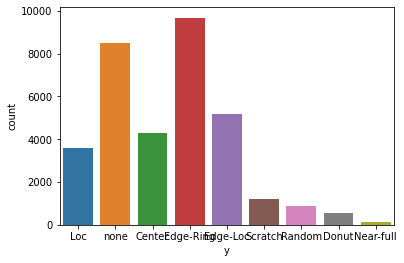

In [ ]:
sns.countplot(batch_fit.y)

In [ ]:
# Start to clean the wafer map data for CNN

In [ ]:
# resize, the dimension of wafer maps are different. 
# need to resize to 1 dimenions. 
x_map=np.array([cv2.resize(img,dsize=(resize_img,resize_img),interpolation=cv2.INTER_CUBIC) for img in x_map])
xmap=x_map/2

In [ ]:
xmap_reshape=xmap.reshape((xmap.shape[0], resize_img,resize_img,1))

In [ ]:
batch_fit.y.unique()


array(['Loc', 'none', 'Center', 'Edge-Ring', 'Edge-Loc', 'Scratch',
       'Random', 'Donut', 'Near-full'], dtype=object)

In [ ]:
def gray_rgb(X_data):
    X=[]

    for i in range(X_data.shape[0]):
        X_temp=X_data[i,:].reshape(resize_img,resize_img,1)
        X_temp_resize= tf.image.resize(X_temp, [resize_img,resize_img])
        X.append(np.concatenate((X_temp_resize,X_temp_resize,X_temp_resize),axis=-1))
    return X

In [ ]:
if RGB==3:
  xmap_reshape=np.asarray(gray_rgb(xmap_reshape))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xmap_reshape, y, test_size=0.2, random_state=101)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(len(X_train), len(y_train))

(27219, 26, 26, 1)
(27219,)
27219 27219


In [ ]:
# Auto Encoder
# Encoder
from keras import layers, Input, models

input_shape = (resize_img,resize_img, RGB)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(RGB, (3,3), padding='same', activation='relu')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
ae.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 1)         577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________

In [ ]:
ae.fit(X_train, X_train,
       batch_size=32,
       epochs=30,
       verbose=2)

Epoch 1/30
851/851 - 18s - loss: 0.0123
Epoch 2/30
851/851 - 2s - loss: 0.0059
Epoch 3/30
851/851 - 2s - loss: 0.0050
Epoch 4/30
851/851 - 2s - loss: 0.0045
Epoch 5/30
851/851 - 2s - loss: 0.0042
Epoch 6/30
851/851 - 2s - loss: 0.0040
Epoch 7/30
851/851 - 2s - loss: 0.0038
Epoch 8/30
851/851 - 2s - loss: 0.0037
Epoch 9/30
851/851 - 2s - loss: 0.0036
Epoch 10/30
851/851 - 2s - loss: 0.0035
Epoch 11/30
851/851 - 2s - loss: 0.0034
Epoch 12/30
851/851 - 2s - loss: 0.0034
Epoch 13/30
851/851 - 2s - loss: 0.0033
Epoch 14/30
851/851 - 2s - loss: 0.0033
Epoch 15/30
851/851 - 2s - loss: 0.0033
Epoch 16/30
851/851 - 2s - loss: 0.0032
Epoch 17/30
851/851 - 2s - loss: 0.0032
Epoch 18/30
851/851 - 2s - loss: 0.0032
Epoch 19/30
851/851 - 2s - loss: 0.0031
Epoch 20/30
851/851 - 2s - loss: 0.0031
Epoch 21/30
851/851 - 2s - loss: 0.0031
Epoch 22/30
851/851 - 2s - loss: 0.0031
Epoch 23/30
851/851 - 2s - loss: 0.0031
Epoch 24/30
851/851 - 2s - loss: 0.0030
Epoch 25/30
851/851 - 2s - loss: 0.0030
Epoch 26

In [ ]:
encoder = models.Model(input_tensor, latent_vector)


In [ ]:
decoder_input = Input((int(resize_img/2), int(resize_img/2), 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
encoded_x = encoder.predict(X_train)


In [ ]:
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.001, size = (len(encoded_x), int(resize_img/2), int(resize_img/2), 64))

In [ ]:
ae_X_train=decoder.predict(noised_encoded_x)

In [ ]:
ae_X_train.shape

(27219, 26, 26, 1)

In [ ]:
X_train.shape

(27219, 26, 26, 1)

In [ ]:
ccc=ae_X_train[12340]/np.max(ae_X_train[12340])
np.max(ccc)
np.min(ccc)

0.0

(-0.5, 25.5, 25.5, -0.5)

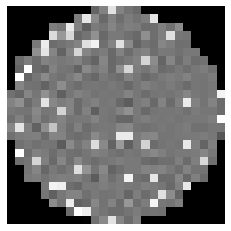

In [ ]:
plt.imshow(ae_X_train[13320].reshape(resize_img,resize_img),  cmap="gray")
plt.axis('off')

(-0.5, 25.5, 25.5, -0.5)

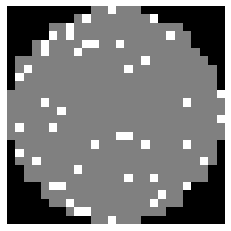

In [ ]:
plt.imshow(X_train[13320].reshape(resize_img,resize_img),  cmap="gray")
plt.axis('off')


In [ ]:
print(len(y_train[y_train=='Donut']))
print(len(y_train[y_train=='Random']))
print(len(y_train[y_train=='Scratch']))
print(len(y_train[y_train=='Near-full']))
repeat_num=2000//116
repeat_num


442
671
979
117


17

In [ ]:
X_train_gene=np.zeros((1, resize_img, resize_img, RGB))
y_train_gene=np.zeros((1))

for label in y_train.unique():
  print(label)
  if len(y_train[y_train==label])<2000:
    for i in range(1+2000//len(y_train[y_train==label])):
      label_index=np.where(y_train==label)
      X_train[label_index].shape
      encoded_x = encoder.predict(X_train[label_index])
      noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.001, size = (len(encoded_x), int(resize_img/2), int(resize_img/2), 64))
      label_index_X_train=decoder.predict(noised_encoded_x)

      X_train_gene=np.append(X_train_gene, label_index_X_train, axis=0)
      y_train_gene=np.append(y_train_gene, y_train[y_train==label], axis=0)

  else:
    label_index=np.where(y_train==label)
    X_train_temp=shuffle(X_train[label_index])
    label_index_X_train2=X_train_temp[0:2000]
    y_train_gene=np.append(y_train_gene, y_train[y_train==label][0:2000], axis=0)
    X_train_gene=np.append(X_train_gene, label_index_X_train2, axis=0)



Center
none
Loc
Edge-Loc
Edge-Ring
Scratch
Donut
Random
Near-full


(19266, 26, 26, 1)
(19266,)


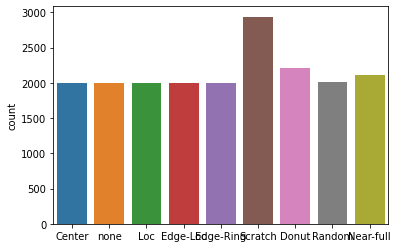

In [ ]:
X_train_gene=X_train_gene[1:]
y_train_gene=y_train_gene[1:]
print(X_train_gene.shape)
print(y_train_gene.shape)
sns.countplot(y_train_gene)

In [ ]:
X_train_gene_backup=X_train_gene[1:]
y_train_gene_backup=y_train_gene[1:]

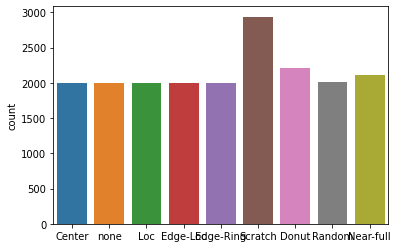

In [ ]:
sns.countplot(y_train_gene_backup)

In [ ]:
encoded_x = encoder.predict(X_test)
ae_X_test=decoder.predict(encoded_x)


In [ ]:
X_train_gene.shape

(19266, 26, 26, 1)

In [ ]:
y_train_gene.shape


(19266,)

In [ ]:
# one hot failure labels
n_classes=batch_fit.y.unique()
n_classes=np.sort(n_classes)
for i, j in enumerate(n_classes):
  y_train_gene[y_train_gene==j]=i
  y_test[y_test==j]=i
y_train_gene=to_categorical(y_train_gene)
y_test=to_categorical(y_test)
n_classes

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype=object)

(19266, 9)
(6805, 9)


array([0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

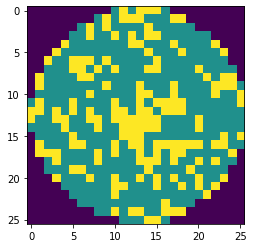

In [ ]:

print(y_train_gene.shape)
print(y_test.shape)
if RGB==3:
  plt.imshow(X_train_gene[11342].reshape(resize_img,resize_img,RGB))
else:
  plt.imshow(X_train_gene[1542].reshape(resize_img,resize_img))

# show resized image
y_train_gene[11342]


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (2,2), padding='same', activation='relu', input_shape = (int(resize_img),int(resize_img),RGB)))

model.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.1))
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.25))

model.add(Flatten())




model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(9, activation='softmax'))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction=ReduceLROnPlateau(monitor= 'loss', patience=3, # loss stop drop and change LR after 3 rounds
                                          verbose=1, # call back factor
                                          factor =0.5, # LR x factor
                                          min_lr=0.0001)

In [ ]:
optimizer=Adam(learning_rate=0.001, beta_1=0.9,beta_2= 0.999)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_gene, y_train_gene, test_size=0.2, random_state=101)


In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation

datagen = ImageDataGenerator(zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rotation_range=20)
datagen.fit(X_train_gene)

In [ ]:
train_generator=datagen.flow(X_train2, y_train2, batch_size=1024, shuffle=True)


In [ ]:
CNN2=model.fit(x=X_train2, y= y_train2,epochs=50,batch_size=128, verbose=2 , validation_data=(X_test,y_test), callbacks=[learning_rate_reduction])

#CNN2=model.fit(x=X_train_gene, y= y_train_gene,epochs=50,batch_size=128, verbose=2 , validation_data=(X_test,y_test), callbacks=[learning_rate_reduction])
#CNN2=model.fit_generator(train_generator, steps_per_epoch = (X_train2.shape[0]//1024), epochs=50, verbose=2,    validation_data=(X_test2,y_test2), callbacks=[learning_rate_reduction])

Epoch 1/50
120/120 - 2s - loss: 0.1386 - accuracy: 0.9512 - val_loss: 1.0734 - val_accuracy: 0.8334
Epoch 2/50
120/120 - 2s - loss: 0.1277 - accuracy: 0.9569 - val_loss: 0.9036 - val_accuracy: 0.8275
Epoch 3/50
120/120 - 2s - loss: 0.1200 - accuracy: 0.9570 - val_loss: 0.9472 - val_accuracy: 0.8464
Epoch 4/50
120/120 - 2s - loss: 0.1097 - accuracy: 0.9621 - val_loss: 0.9991 - val_accuracy: 0.8398
Epoch 5/50
120/120 - 2s - loss: 0.1033 - accuracy: 0.9638 - val_loss: 0.8685 - val_accuracy: 0.8529
Epoch 6/50
120/120 - 2s - loss: 0.0948 - accuracy: 0.9681 - val_loss: 0.7584 - val_accuracy: 0.8557
Epoch 7/50
120/120 - 2s - loss: 0.0828 - accuracy: 0.9722 - val_loss: 1.1674 - val_accuracy: 0.8398
Epoch 8/50
120/120 - 2s - loss: 0.0796 - accuracy: 0.9739 - val_loss: 0.8979 - val_accuracy: 0.8497
Epoch 9/50
120/120 - 2s - loss: 0.0867 - accuracy: 0.9711 - val_loss: 0.9655 - val_accuracy: 0.8414
Epoch 10/50
120/120 - 2s - loss: 0.0709 - accuracy: 0.9767 - val_loss: 0.9694 - val_accuracy: 0.8454

In [ ]:
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(15412, 26, 26, 1) (3854, 26, 26, 1) (15412, 9) (3854, 9)


In [ ]:
def gray_rgb(X_data):
    X=[]

    for i in range(X_data.shape[0]):
        X_temp=X_data[i,:].reshape(26,26,1)
        X_temp_resize= tf.image.resize(X_temp, [112,112])
        X.append(np.concatenate((X_temp_resize,X_temp_resize,X_temp_resize),axis=-1))
    return X

In [ ]:
X_train3=np.asarray(gray_rgb(X_train2))
X_test3=np.asarray(gray_rgb(X_test2))



In [ ]:
X_train4=np.asarray(gray_rgb(X_train))
X_test4=np.asarray(gray_rgb(X_test))

In [ ]:
print(X_train4.shape, X_test4.shape, y_train.shape, y_test.shape)

(27219, 112, 112, 3) (6805, 112, 112, 3) (27219,) (6805, 9)


(15412, 112, 112, 3) (3854, 112, 112, 3) (15412, 9) (3854, 9)


In [ ]:
for i, j in enumerate(n_classes):
  y_train[y_train==j]=i
y_train=to_categorical(y_train)


In [ ]:
print(X_train3.shape, X_test3.shape, y_train2.shape, y_test2.shape)

(15412, 112, 112, 3) (3854, 112, 112, 3) (15412, 9) (3854, 9)


In [ ]:
base_model=tf.keras.applications.MobileNetV2(
    input_shape=(112,112,3), alpha=1.0, include_top=False, weights='imagenet',
    input_tensor=None, pooling=None)

In [ ]:
model2 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
  model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
c=model2.fit(x=X_train4, y=y_train,epochs=100,batch_size=32, validation_data=(X_test4,y_test), shuffle=True)

Epoch 1/100
851/851 [==============================] - 48s 52ms/step - loss: 0.9929 - accuracy: 0.6958 - val_loss: 6.9877 - val_accuracy: 0.3142
Epoch 2/100
851/851 [==============================] - 43s 51ms/step - loss: 0.4721 - accuracy: 0.8426 - val_loss: 8.6694 - val_accuracy: 0.3978
Epoch 3/100
851/851 [==============================] - 42s 50ms/step - loss: 0.4174 - accuracy: 0.8576 - val_loss: 4.1862 - val_accuracy: 0.5542
Epoch 4/100
851/851 [==============================] - 43s 51ms/step - loss: 0.3735 - accuracy: 0.8732 - val_loss: 2.9390 - val_accuracy: 0.5436
Epoch 5/100
851/851 [==============================] - 43s 51ms/step - loss: 0.3365 - accuracy: 0.8845 - val_loss: 1.1752 - val_accuracy: 0.7195
Epoch 6/100
851/851 [==============================] - 44s 51ms/step - loss: 0.3216 - accuracy: 0.8895 - val_loss: 4.1285 - val_accuracy: 0.6429
Epoch 7/100
851/851 [==============================] - 43s 51ms/step - loss: 0.2937 - accuracy: 0.8993 - val_loss: 2.7990 - val_ac

In [ ]:
accuracy  = c.history['accuracy']
val_accuracy = c.history['val_accuracy']

val_loss=c.history['val_loss']
loss=c.history['loss']

train_epoch=range(1,101)
plt.plot(train_epoch,accuracy , label='accuracy')
plt.plot(train_epoch,val_accuracy , label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

text=('best accuracy' ,max(val_accuracy),)

plt.text(1,0.9940,text,fontsize =12)


NameError: ignored

In [ ]:
df=pd.DataFrame()
df['epoch']=train_epoch
df['val_acc']=val_accuracy
df['test_acc']=accuracy
df['val_loss']=val_loss
df['test_loss']=loss
df.to_csv('Alexnet1.csv') 

from google.colab import files
files.download("Alexnet1.csv")

In [ ]:
y_test_pred=np.round(model.predict(X_test3),0)
y_test_pred.shape

y_predict_classes = [np.argmax(y, axis=None, out=None) for y in y_test_pred]
y_test_class= [np.argmax(y, axis=None, out=None) for y in y_test]
len(y_test_class)

In [ ]:
np.sort(n_classes)

In [ ]:
from sklearn import metrics

classification_metrics=metrics.classification_report(y_predict_classes,y_test_class, target_names=n_classes)
print(classification_metrics)

              precision    recall  f1-score   support

      Center       0.98      0.88      0.93       997
       Donut       0.23      0.97      0.37        30
    Edge-Loc       0.86      0.80      0.83      1094
   Edge-Ring       0.98      0.97      0.97      2005
         Loc       0.80      0.61      0.69       915
   Near-full       0.86      0.97      0.91        31
      Random       0.08      1.00      0.15        13
     Scratch       0.00      0.00      0.00         0
        none       0.92      0.89      0.91      1720

    accuracy                           0.86      6805
   macro avg       0.63      0.79      0.64      6805
weighted avg       0.92      0.86      0.89      6805



In [ ]:
y_predict_classes=pd.DataFrame(y_predict_classes)
y_test_class=pd.DataFrame(y_test_class)

for i, j in enumerate(n_classes):

  y_predict_classes[y_predict_classes==i]=n_classes[i]
  y_test_class[y_test_class==i]=n_classes[i]
y_predict_classes=y_predict_classes.to_numpy()
y_test_class=y_test_class.to_numpy()
y_predict_classes

array([['Edge-Ring'],
       ['none'],
       ['Edge-Loc'],
       ...,
       ['none'],
       ['Edge-Ring'],
       ['Edge-Ring']], dtype=object)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

Normalized confusion matrix


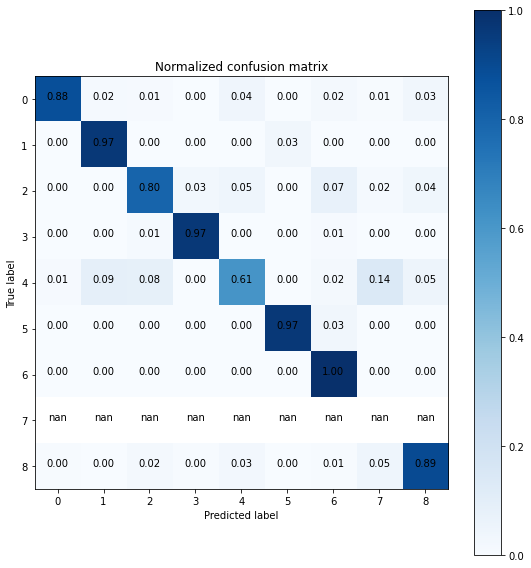

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cnf_matrix = confusion_matrix(y_predict_classes, y_test_class)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 



# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix,   title='Normalized confusion matrix', normalize=True )


plt.show()

In [ ]:
n_classes

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype=object)

In [ ]:
y_predict_classes

array([['Edge-Ring'],
       ['none'],
       ['Edge-Loc'],
       ...,
       ['none'],
       ['Edge-Ring'],
       ['Edge-Ring']], dtype=object)

In [ ]:
y_predict_classes


In [ ]:
n_classes[1]

In [ ]:
y_predict_classes